# Data Prep

In this notebook I will import and inspect the image and telemetry data taken from Donkey Sim, and organize it for modeling steps.

* Import telemetry .csv
* Import image data
* Convert image data
* Create dataframe with: 
  * steering inputs, 
  * throttle inputs
  * converted imageds
* Save as a pickle format file for modeling

In [1]:
## Imports
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle

from tensorflow.keras.preprocessing.image import img_to_array, load_img

2021-11-15 10:20:03.070103: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## Telemetry Data

Steps:
* load simulation telemetry data csv
* cut unneeded columns
* cut incomplete last lap
* import images as numpy arrays
* create numpy array of image data arrays
* save images as input dataset X
* save steering angle and throttle data in numpy array as target dataset y


In [2]:
## Constants
working_date = '11_14_2021'
working_time = '19_32_37'
local_project_path = '/home/grant/projects/donkeysim-client/data'

In [3]:
## Directories
local_data_directory = f'{local_project_path}/{working_date}/{working_time}'
local_image_directory = f'{local_data_directory}/images'
working_data_directory = f'../data/{working_date}/{working_time}'

## File paths
telemetry_csv = f'{local_data_directory}/data.csv'
input_image_dataset_file = f'{working_data_directory}/X_img.npy'
input_imu_dataset_file = f'{working_data_directory}/X_imu.pkl'
target_dataset_file = f'{working_data_directory}/y.npy'

In [4]:
## Make sure directoires exist
os.makedirs(working_data_directory, exist_ok=True)

### Load CSV file as DataFrame

In [5]:
df = pd.read_csv(telemetry_csv)
df.head()

,steering_angle,throttle,speed,image,hit,time,accel_x,accel_y,accel_z,gyro_x,...,totalNodes,pos_x,pos_y,pos_z,vel_x,vel_y,vel_z,on_road,progress_on_shortest_path,lap
0,0.0,0.227762,0.017316,4.992752.PNG,none,4.992752,0.000239,0.000895,1.195430,0.000175,...,307,14.03981,0.565237,-68.18562,0.000084,-0.000800,0.017297,0,0,0
1,0.0,0.238514,0.040147,5.025918.PNG,none,5.025918,-0.003935,0.013784,0.995404,0.000349,...,307,14.03861,0.565034,-68.18688,0.000108,-0.000333,0.040146,0,0,0
2,0.0,0.240469,0.079855,5.092834.PNG,none,5.092834,-0.009481,0.023776,0.936873,0.000470,...,307,14.03587,0.564835,-68.18987,-0.000094,0.001050,0.079848,0,0,0
3,0.0,0.240469,0.100219,5.143176.PNG,none,5.143176,0.001526,0.022555,0.894351,0.000387,...,307,14.03312,0.564787,-68.19279,-0.000051,0.002099,0.100197,0,0,0
4,0.0,0.227762,0.128075,5.175912.PNG,none,5.175912,0.009088,0.018956,0.764733,0.000321,...,307,14.02952,0.564822,-68.19651,-0.000011,0.002954,0.128041,0,0,0


In [6]:
## drop telemetry column
df.reset_index(drop=True, inplace=True)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16898 entries, 0 to 16897
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   steering_angle             16898 non-null  float64
 1   throttle                   16898 non-null  float64
 2   speed                      16898 non-null  float64
 3   image                      16898 non-null  object 
 4   hit                        16898 non-null  object 
 5   time                       16898 non-null  float64
 6   accel_x                    16898 non-null  float64
 7   accel_y                    16898 non-null  float64
 8   accel_z                    16898 non-null  float64
 9   gyro_x                     16898 non-null  float64
 10  gyro_y                     16898 non-null  float64
 11  gyro_z                     16898 non-null  float64
 12  gyro_w                     16898 non-null  float64
 13  pitch                      16898 non-null  flo

In [8]:
df.columns

Index(['steering_angle', 'throttle', 'speed', 'image', 'hit', 'time',
       'accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z', 'gyro_w',
       'pitch', 'yaw', 'roll', 'cte', 'activeNode', 'totalNodes', 'pos_x',
       'pos_y', 'pos_z', 'vel_x', 'vel_y', 'vel_z', 'on_road',
       'progress_on_shortest_path', 'lap'],
      dtype='object')

In [9]:
df.drop(columns=['speed','hit', 'pitch', 'yaw', 'roll', 'cte', 
                 'activeNode', 'totalNodes', 'pos_x', 'pos_y', 'pos_z', 
                 'on_road', 'progress_on_shortest_path',], inplace=True)

In [10]:
df.lap.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21])

In [11]:
sys.getsizeof(df)

3056623

In [12]:
df.dtypes

steering_angle    float64
throttle          float64
image              object
time              float64
accel_x           float64
accel_y           float64
accel_z           float64
gyro_x            float64
gyro_y            float64
gyro_z            float64
gyro_w            float64
vel_x             float64
vel_y             float64
vel_z             float64
lap                 int64
dtype: object

### Convert datatypes (?)

In [13]:
for col in df.columns:
    if df[col].dtype == 'float':
        df[col] = pd.to_numeric(df[col], downcast='float')

In [14]:
sys.getsizeof(df)

2177927

### Remove "Extra" Laps

In [15]:
## Cut off the little bit after the end of the training session
df = df.loc[(df['lap'] > 0) & (df['lap'] < df['lap'].max()), :] #.drop(columns='lap')
df['lap'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

### Convert lap to category

In [16]:
df.loc[:, 'lap'] = df.loc[:, 'lap'].astype('category')

In [17]:
sys.getsizeof(df)

2178259

### Create lap time df

In [18]:
laps = pd.DataFrame(df.groupby(by='lap')['time'].describe()[['max', 'min']])
laps.head()

,max,min
lap,,
1,53.530800,7.192870
2,96.338257,53.581081
3,137.778198,96.388573
4,178.981995,137.828506
5,219.734604,179.031799


In [19]:
laps['lap_time'] = laps['max'] - laps['min']
laps['lap_time'].describe()

count    20.000000
mean     41.865237
std       1.235858
min      40.702805
25%      41.156338
50%      41.441013
75%      42.366119
max      46.337930
Name: lap_time, dtype: float64

*analysis*: The slowest lap took 48.2 seconds, the shortest 40.2, with the mean being somewhere around 41.3. This suggests to me that the value might lie less in emphasizing the fastest laps than in cutting the slowest ones.

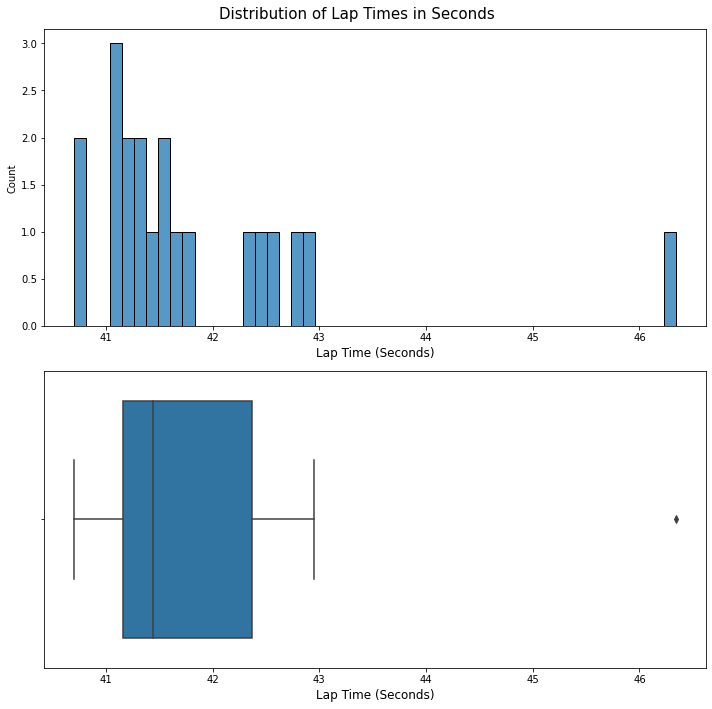

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))
plt.suptitle('Distribution of Lap Times in Seconds', size=15)
ax[0] = sns.histplot(x='lap_time', data=laps, bins=50, ax=ax[0])
ax[0].set_xlabel('Lap Time (Seconds)', size=12)
ax[1] = sns.boxplot(x='lap_time', data=laps, ax=ax[1])
ax[1].set_xlabel('Lap Time (Seconds)', size=12)
plt.tight_layout();

In [21]:
len(laps[laps['lap_time']>43])

1

### Add lap times to df to make sorting easier

In [22]:
df = pd.merge(left=df, right=laps['lap_time'], left_on='lap', right_index=True).copy()

### Cut laps longer than 43 seconds

In [23]:
df = df.loc[df['lap_time'] < 43, :].copy()
df.drop(columns=['lap', 'time', 'lap_time'], inplace=True)
df.shape

(15838, 13)

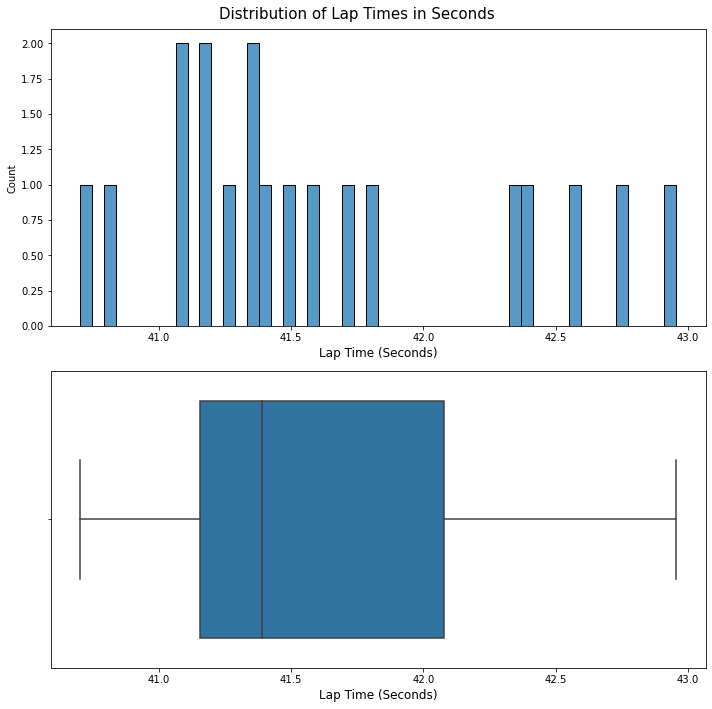

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))
plt.suptitle('Distribution of Lap Times in Seconds', size=15)
ax[0] = sns.histplot(x='lap_time', data=laps.loc[laps['lap_time'] < 43], bins=50, ax=ax[0])
ax[0].set_xlabel('Lap Time (Seconds)', size=12)
ax[1] = sns.boxplot(x='lap_time', data=laps.loc[laps['lap_time'] < 43], ax=ax[1])
ax[1].set_xlabel('Lap Time (Seconds)', size=12)
plt.tight_layout();

### Rename Steering Column to Match Throttle

In [29]:
df.columns = ['steering' if col=='steering_angle' else col for col in df.columns]
df.columns

Index(['steering', 'throttle', 'image', 'accel_x', 'accel_y', 'accel_z',
       'gyro_x', 'gyro_y', 'gyro_z', 'gyro_w', 'vel_x', 'vel_y', 'vel_z'],
      dtype='object')

### Examine IMU Data

In [32]:
## IMU columns we are CURRENTLY INTERESTED IN
## note that gyro_w is always 1.0 and of no use
imu_columns = ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 
               'gyro_z', 'vel_x', 'vel_y', 'vel_z',]

In [33]:
X_imu = df[imu_columns]
X_imu.columns

Index(['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z', 'vel_x',
       'vel_y', 'vel_z'],
      dtype='object')

In [85]:
imu_stats = X_imu.describe().T[['min', 'max', 'mean']]

imu_stats['abs_max'] = imu_stats['max'].abs()
imu_stats['abs_min'] = imu_stats['min'].abs()
imu_stats['max_mag'] = imu_stats.loc[:, ['abs_min', 'abs_max']].max(axis=1)
imu_stats

,min,max,mean,abs_max,abs_min,max_mag
accel_x,-84.802498,94.708817,0.000421,94.708817,84.802498,94.708817
accel_y,-12.386760,53.589142,-0.001007,53.589142,12.386760,53.589142
accel_z,-49.931122,10.457180,-0.003439,10.457180,49.931122,49.931122
gyro_x,-0.023662,0.015879,0.000018,0.015879,0.023662,0.023662
gyro_y,-0.032501,0.040941,0.001518,0.040941,0.032501,0.040941
gyro_z,-0.016708,0.033302,-0.000021,0.033302,0.016708,0.033302
vel_x,-8.900988,5.964907,-0.360510,5.964907,8.900988,8.900988
vel_y,-1.339154,1.289006,-0.124751,1.289006,1.339154,1.339154
vel_z,4.117527,18.467470,12.710043,18.467470,4.117527,18.467470


### Save IMU Data

In [34]:
## Make sure directoires exist
os.makedirs(working_data_directory, exist_ok=True)

## Save as pickle
X_imu.to_pickle(input_imu_dataset_file)

## Image Data

### Verify Files

In [35]:
## Verify Files
os.listdir(local_image_directory)[:5]

['687.1882.PNG', '769.528.PNG', '533.4342.PNG', '115.0398.PNG', '438.534.PNG']

## Create Image Array

In [36]:
## Using keras, load images as list, adding to a list
img_array_list = []
for img in df['image']:
    img_array_list.append(img_to_array(load_img(f"{local_image_directory}/{img}", 
                                                color_mode='grayscale',))) 
                                                # target_size=(60, 80))))

In [37]:
## convert list of arrays into a numpy array (of arrays())
X_img = np.array(img_array_list)

## Create Datasets

### Create Targets

In [38]:
## Target: throttle and steering data
# y = df.drop(columns=['image']).to_numpy().copy()
y = df.loc[:, ['steering', 'throttle']].to_numpy().copy()

## Verify size
print(f'X.shape: {X_img.shape}')
print(f'y.shape: {y.shape}')

X.shape: (15838, 120, 160, 1)
y.shape: (15838, 2)


### Scale Image Data

In [39]:
X_img /= 255

### Save Datasets

In [40]:
## Save as binary NumPy .npy format
with open(input_image_dataset_file, 'wb') as X_out:
    np.save(file=X_out, arr=X_img)
with open(target_dataset_file, 'wb') as y_out:
    np.save(file=y_out, arr=y)